## [Part of laboratory work](#lab)

0. [Функция для вывода графиков Training Loss, MSE/MAE.](#graph)
1. [Развить СNN архитектуру (2 балла)](#first)
2. [Pooling слои стандартные (1 балла)](#second)
3. [Используйте предобученные эмбеддинги (2 балла)](#third)
4. [Замените сверточные слои на рекуррентные (3 балла)](#fourth)
5. [Вытащите признаки из нейронной сети и используйте их в ансамбле деревьев решений. (2 балла)](#fifth)

### Overview

Были выполнены все задания, протестировано достаточно большое количество предложенных моделей. К некоторым заданиям не сохраняла модели, дающие низкие результаты, старалась акцентировать внимание на лучших. Результаты всех моделей примерно одинаковые: MSE/MAE варьируются в пределах от 0.02 до 0.3, лучшая модель (спойлер) построена на основе предобученных эмбеддингов.

Каждое представленное решение проиллюстрировано графиком, который содержит данные о динамике train loss, MSE/MAE, а также стандартными статистиками: макс, мин, среднее, медиана, дисперсия.

Количество эпох практически во всех примерах - 3, так как большее не позволяют выполнить мощности ноутбука.

# Large scale text analysis with deep learning (3 points)

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

_Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here]. 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [2]:
# !wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
# !unzip Train_rev1.zip
data = pd.read_csv("Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

In [3]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

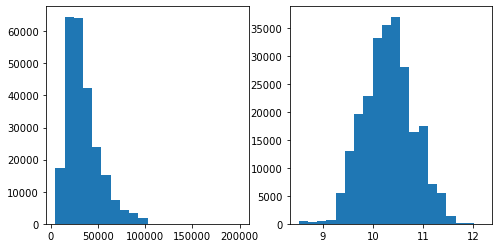

In [4]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [5]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"
data[text_columns] = data[text_columns].fillna('NaN')

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
133255,70239482,Senior Credit Risk Modelling Consultant,Our client is an established consultancy with ...,"North West England, Cheshire",Cheshire,NaN,NaN,Aspire Data Recrutiment,Other/General Jobs,"50,000-74,999 yearly",62499,theladders.co.uk,11.042922
24941,67751933,Net Analyst/Developer Financial Services X****,Analyst/Developer Financial Services; Our clie...,City of London London England,The City,NaN,NaN,Interquest Financial Markets,IT Jobs,55000 -65000 per annum,60000,gojobsearch.co.uk,11.002116
202201,71885992,Deputy Manager Nursing Home RGN,Deputy Nursing Home Manager (RGN) Shropshire ...,"Shropshire, Shropshire",Shropshire,NaN,NaN,NaN,Healthcare & Nursing Jobs,27000 to 35000 per year,31000,careworx.co.uk,10.341775


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [6]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [7]:
import nltk
#TODO YOUR CODE HERE

tokenizer = nltk.tokenize.WordPunctTokenizer()
# YOUR CODE HERE

data[text_columns] = data[text_columns].applymap(lambda x: " ".join(tokenizer.tokenize(x.lower())))

Now we can assume that our text is a space-separated list of tokens:

In [8]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [9]:
from collections import Counter
token_counts = Counter()
# Count how many times does each token occur in both "Title" and "FullDescription" in total
#TODO <YOUR CODE>

for col in text_columns:
    for line in data[col].values:
        token_counts.update(line.split(" "))

In [10]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


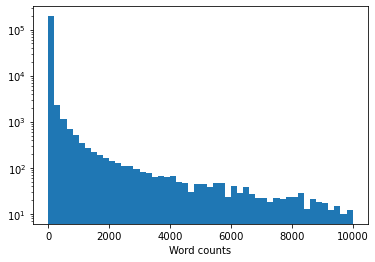

In [11]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [12]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
#TODO <YOUR CODE>
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [13]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [14]:
# TODO <YOUR CODE>
token_to_id = {t: i for i, t in enumerate(tokens)}

In [15]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [16]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [17]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [18]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [19]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=77)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [20]:
import torch

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [21]:
make_batch(data_train[:3], max_len=10)

{'Title': tensor([[27645, 26986,  1587,   197, 11192,  1700],
         [27280, 13650, 30409,  2844,     1,     1],
         [ 4986,  9083, 18864,     1,     1,     1]]),
 'FullDescription': tensor([[32937, 31100, 33664, 12587,   982, 17753, 11192,  1693,   943,  8110],
         [ 2572, 33996,   982, 13650,   158, 33554,   982,   437, 22021,    82],
         [33996, 33435, 30323, 33554,  3002, 20893, 11312,   158,  7151, 31100]]),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'Log1pSalary': tensor([10.5967,  9.5325, 10.4631])}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use PyTorch.

In [22]:
import torch
import torch.nn as nn
import torch.functional as F

In [23]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        #  YOUR CODE HERE

        
    def forward(self, batch):
        # YOUR CODE HERE
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [24]:
model = SalaryPredictor()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(np.unique(dummy_pred.detach().numpy())) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [25]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [26]:
import tqdm

BATCH_SIZE = 128
EPOCHS = 3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
def print_metrics(model, data, list_mse, list_mae, batch_size=BATCH_SIZE, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.mean(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.mean(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch)
    mse = squared_error.detach().cpu().numpy() / num_samples
    list_mse.append(mse)
    mae = abs_error.detach().cpu().numpy() / num_samples
    list_mae.append(mae)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

In [28]:
model = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
list_mse_1 = []
list_mae_1 = []
train_loss_1 = []

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()

        if i % 100 == 99:
            print('train_loss', loss.item())
            train_loss_1.append(loss.item())
            print_metrics(model, data_val, list_mse=list_mse_1, list_mae=list_mae_1, 
                          name='val', batch_size=BATCH_SIZE, device=DEVICE)

epoch: 0


train_loss 5.680886745452881
val results:
Mean square error: 3.38062
Mean absolute error: 0.90840
train_loss 0.46588006615638733
val results:
Mean square error: 0.90797
Mean absolute error: 0.45397
train_loss 0.2983931601047516
val results:
Mean square error: 0.88974
Mean absolute error: 0.45138
train_loss 0.3978468179702759
val results:
Mean square error: 0.84508
Mean absolute error: 0.44072
train_loss 0.33900174498558044
val results:
Mean square error: 0.84784
Mean absolute error: 0.44301
train_loss 0.3814780116081238
val results:
Mean square error: 0.84443
Mean absolute error: 0.44323
train_loss 0.3178771734237671
val results:
Mean square error: 0.83875
Mean absolute error: 0.44246
train_loss 0.26624777913093567
val results:
Mean square error: 0.80168
Mean absolute error: 0.43258
train_loss 0.2721179723739624
val results:
Mean square error: 0.77602
Mean absolute error: 0.42573
train_loss 0.2262079119682312
val results:
Mean square error: 0.78206
Mean absolute error: 0.42803
train_lo

train_loss 0.16926760971546173
val results:
Mean square error: 0.60761
Mean absolute error: 0.37698
train_loss 0.17368389666080475
val results:
Mean square error: 0.62300
Mean absolute error: 0.38222
train_loss 0.1835559606552124
val results:
Mean square error: 0.60606
Mean absolute error: 0.37689
train_loss 0.1890726536512375
val results:
Mean square error: 0.56960
Mean absolute error: 0.36485
train_loss 0.151182159781456
val results:
Mean square error: 0.55337
Mean absolute error: 0.35944
train_loss 0.18213969469070435
val results:
Mean square error: 0.54970
Mean absolute error: 0.35841
train_loss 0.1687617301940918
val results:
Mean square error: 0.53984
Mean absolute error: 0.35524
train_loss 0.19337908923625946
val results:
Mean square error: 0.53910
Mean absolute error: 0.35519
train_loss 0.1499251425266266
val results:
Mean square error: 0.52160
Mean absolute error: 0.34915
train_loss 0.1504993587732315
val results:
Mean square error: 0.51821
Mean absolute error: 0.34809
train_l

train_loss 0.1015489250421524
val results:
Mean square error: 0.41555
Mean absolute error: 0.31037
train_loss 0.15778231620788574
val results:
Mean square error: 0.42051
Mean absolute error: 0.31245
train_loss 0.12496434897184372
val results:
Mean square error: 0.40836
Mean absolute error: 0.30767
train_loss 0.11393605172634125
val results:
Mean square error: 0.43051
Mean absolute error: 0.31666
train_loss 0.12034003436565399
val results:
Mean square error: 0.38672
Mean absolute error: 0.29901
train_loss 0.12835055589675903
val results:
Mean square error: 0.38062
Mean absolute error: 0.29654
train_loss 0.11490476131439209
val results:
Mean square error: 0.37538
Mean absolute error: 0.29434
train_loss 0.1259652078151703
val results:
Mean square error: 0.37429
Mean absolute error: 0.29402
train_loss 0.11528874933719635
val results:
Mean square error: 0.36735
Mean absolute error: 0.29110
train_loss 0.10789896547794342
val results:
Mean square error: 0.36095
Mean absolute error: 0.28849
tr

In [29]:
# conda install pytorch torchvision cudatoolkit=10.2 -c pytorch

### Part of laboratory work <a name="lab"></a>

**0. Функция для вывода графиков Training Loss, MSE/MAE.**<a name="graph"></a>

In [28]:
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
py.init_notebook_mode(connected=True)

In [29]:
def draw_loss_acc_plot(model, train_loss, list_mae, list_mse):
    
    trace1 = go.Scatter(x=np.arange(len(train_loss)), y=train_loss,
                        mode='lines',
                        name='Train Loss', showlegend=False)
    
    trace2 = go.Scatter(x=np.arange(len(list_mae)), y=list_mae,
                        mode='lines',
                        name='MAE')
    trace3 = go.Scatter(x=np.arange(len(list_mse)), y=list_mse,
                        mode='lines',
                        name='MSE')

    fig = make_subplots(rows=2, cols=1, print_grid=False, 
                        specs=[[{}], 
                               [{}]],
                        subplot_titles=('<b>Train Loss</b>', '<b>Test Metrics</b>'),
                       )
    
    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 2, 1)
    fig.append_trace(trace3, 2, 1)
    
    train_loss_stats = [np.max(train_loss), np.mean(train_loss), np.min(train_loss), np.median(train_loss), np.var(train_loss)]
    list_mae_stats = [np.max(list_mae), np.mean(list_mae), np.min(list_mae), np.median(list_mae), np.var(list_mae)]
    list_mse_stats = [np.max(list_mse), np.mean(list_mse), np.min(list_mse), np.median(list_mse), np.var(list_mse)]
    
    fig["layout"].update(legend=dict(x=1, y=0.15),
                         title={'text': '<b>Model performance report</b><br>' + str(model) + '<br>' * 24 \
                                                  + '<b><i>Train Loss Stat Values:</i></b><br>' \
                                                  + 'Max: {:.2f}   Mean: {:.2f}   Min: {:.2f}   Median: {:.2f}   Var: {:.2f}'.format(*train_loss_stats) \
                                                  + '<br><br><b><i>Mean Absolute Error Stat Values:</i></b><br>' \
                                                  + 'Max: {:.2f}   Mean: {:.2f}   Min: {:.2f}   Median: {:.2f}   Var: {:.2f}'.format(*list_mae_stats) \
                                                  + '<br><br><b><i>Mean Squared Error Stat Values:</i></b><br>' \
                                                  + 'Max: {:.2f}   Mean: {:.2f}   Min: {:.2f}   Median: {:.2f}   Var: {:.2f}'.format(*list_mse_stats),
                                                  'x': 0.5,
                                                  'y': 0.95,
                                                  'xanchor': 'center',
                                                  'yanchor': 'top'},
                         autosize=False, height=780, width=900,
                         plot_bgcolor='rgba(240, 240, 240, 0.95)',
                         paper_bgcolor='rgba(240, 240, 240, 0.95)',
                         margin=dict(b=270))
    
    fig["layout"]["yaxis1"].update(dict(range=[0, 1]))
    fig["layout"]["yaxis2"].update(dict(range=[0, 1]))
    
    py.iplot(fig)

Вам нужно будет взять [ноутбук](https://drive.google.com/file/d/1euxnmvVeE5byHiTd-axQz4pF9wgEHXmQ/view?usp=sharing) с предсказанием заработной платы, который  Вы разбирали на практике, и улучшить его.

Несколько советов по оформлениею работы:
*   В начале ноутбука добавьте небольшое резюме - что Вами было сделано в ноутбуке: что попробовали, какие результаты получили.
*   Все эксперименты оформите с графиками функции потерь и метриками MAE, MSE. Графики постройте на тренировочных, тестовых и валидационных данных. В конце каждого эксперимента выведите лучшие значения.
*   В конце каждого эксперимента напишите свои выводы. Подкрепите их визуализацией и/или метриками.

**1. Развить СNN архитектуру (2 балла)**<a name="first"></a>

Добавить в пайплайн:

*   Batch Norm (nn.BatchNorm)
*   Параллельные сверточные слои. Идея в том, чтобы применить несколько nn.Conv1d к одному и тому же эмбеддингу и после этого сконкатенировать выходные каналы
*   Больше слоев...
*   Добавить раннюю остановку

На каких примерах модели ведут себя максимально различно/похоже? Предположите с чем это может быть связано. 

Как модель ведет себя в зависимости от количества обучаемых параметров?

**Добавление слоя nn.BatchNorm1d**

In [32]:
class SalaryPredictorwBatchNorm(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.BatchNorm1d(hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
    
    def forward(self, batch):
        
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [33]:
model = SalaryPredictorwBatchNorm()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(np.unique(dummy_pred.detach().numpy())) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

In [34]:
model = SalaryPredictorwBatchNorm().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
list_mse_2 = []
list_mae_2 = []
train_loss_2 = []

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()

        if i % 100 == 99:
            print('train_loss', loss.item())
            train_loss_2.append(loss.item())
            print_metrics(model, data_val, list_mse=list_mse_2, list_mae=list_mae_2, 
                          name='val', batch_size=BATCH_SIZE, device=DEVICE)

epoch: 0


train_loss 89.75553131103516
val results:
Mean square error: 22.58736
Mean absolute error: 2.37258
train_loss 73.69219970703125
val results:
Mean square error: 19.10619
Mean absolute error: 2.18182
train_loss 54.730716705322266
val results:
Mean square error: 14.01105
Mean absolute error: 1.86642
train_loss 36.54741287231445
val results:
Mean square error: 9.41030
Mean absolute error: 1.52563
train_loss 22.134138107299805
val results:
Mean square error: 5.78977
Mean absolute error: 1.18835
train_loss 10.451841354370117
val results:
Mean square error: 2.94355
Mean absolute error: 0.83276
train_loss 4.6217145919799805
val results:
Mean square error: 1.59845
Mean absolute error: 0.59899
train_loss 1.5466071367263794
val results:
Mean square error: 0.95273
Mean absolute error: 0.44267
train_loss 0.6198590397834778
val results:
Mean square error: 0.37592
Mean absolute error: 0.26005
train_loss 0.7001397609710693
val results:
Mean square error: 0.19474
Mean absolute error: 0.18297
train_loss

train_loss 0.2308236062526703
val results:
Mean square error: 0.14624
Mean absolute error: 0.15745
train_loss 0.3124167323112488
val results:
Mean square error: 0.10819
Mean absolute error: 0.13268
train_loss 0.20998071134090424
val results:
Mean square error: 0.09994
Mean absolute error: 0.12701
train_loss 0.2337658405303955
val results:
Mean square error: 0.13656
Mean absolute error: 0.15002
train_loss 0.2197832614183426
val results:
Mean square error: 0.09802
Mean absolute error: 0.12665
train_loss 0.20295287668704987
val results:
Mean square error: 0.08782
Mean absolute error: 0.11810
train_loss 0.18855951726436615
val results:
Mean square error: 0.09502
Mean absolute error: 0.12342
train_loss 0.2345656156539917
val results:
Mean square error: 0.09849
Mean absolute error: 0.12485
train_loss 0.23774179816246033
val results:
Mean square error: 0.09347
Mean absolute error: 0.12143
train_loss 0.15135852992534637
val results:
Mean square error: 0.10756
Mean absolute error: 0.13113
train

train_loss 0.14105388522148132
val results:
Mean square error: 0.06930
Mean absolute error: 0.10377
train_loss 0.18966911733150482
val results:
Mean square error: 0.07935
Mean absolute error: 0.11128
train_loss 0.1297878473997116
val results:
Mean square error: 0.06689
Mean absolute error: 0.10197
train_loss 0.21387675404548645
val results:
Mean square error: 0.06860
Mean absolute error: 0.10325
train_loss 0.1599457561969757
val results:
Mean square error: 0.07480
Mean absolute error: 0.10818
train_loss 0.15079322457313538
val results:
Mean square error: 0.05966
Mean absolute error: 0.09743
train_loss 0.1687903106212616
val results:
Mean square error: 0.08970
Mean absolute error: 0.12177
train_loss 0.18250615894794464
val results:
Mean square error: 0.08076
Mean absolute error: 0.11318
train_loss 0.16538399457931519
val results:
Mean square error: 0.06261
Mean absolute error: 0.09836
train_loss 0.11359822750091553
val results:
Mean square error: 0.07756
Mean absolute error: 0.11076
tra

In [35]:
draw_loss_acc_plot('Salary Predictor with BatchNorm', train_loss_2, list_mae_2, list_mse_2)

**Добавление дополнительных слоёв nn.Conv1d (лучшая модель, которая получилась методом проб и ошибок)**

In [46]:
class SalaryPredictorwBatchNormAddLayers(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.conv1 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU()
        )
        self.pool1 = nn.AdaptiveAvgPool1d(output_size=1)
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU())
        self.pool2 = nn.AdaptiveAvgPool1d(output_size=1)
        
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.BatchNorm1d(hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 5, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)

        title_conv_features1 = self.conv1(title_embeddings)
        title_features1 = self.pool1(title_conv_features1).squeeze()

        title_conv_features2 = self.conv2(title_embeddings)
        title_features2 = self.pool2(title_conv_features2).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'].float())

        features = torch.cat(
            [title_features1, title_features2, description_features, categorical_features], dim=1)

        return self.final_predictor(features).squeeze()

In [47]:
model = SalaryPredictorwBatchNormAddLayers()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(np.unique(dummy_pred.detach().numpy())) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

In [106]:
model = SalaryPredictorwBatchNormAddLayers().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
list_mse_3 = []
list_mae_3 = []
train_loss_3 = []

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()

        if i % 100 == 99:
            print('train_loss', loss.item())
            train_loss_3.append(loss.item())
            print_metrics(model, data_val, list_mse=list_mse_3, list_mae=list_mae_3, 
                          name='val', batch_size=BATCH_SIZE, device=DEVICE)

epoch: 0


train_loss 101.52289581298828
val results:
Mean square error: 24.00486
Mean absolute error: 2.44569
train_loss 90.66921997070312
val results:
Mean square error: 22.22759
Mean absolute error: 2.35247
train_loss 76.26687622070312
val results:
Mean square error: 18.68001
Mean absolute error: 2.15474
train_loss 57.38813781738281
val results:
Mean square error: 13.92986
Mean absolute error: 1.85850
train_loss 39.011810302734375
val results:
Mean square error: 9.42909
Mean absolute error: 1.52414
train_loss 23.219078063964844
val results:
Mean square error: 5.50487
Mean absolute error: 1.15592
train_loss 11.526031494140625
val results:
Mean square error: 2.89098
Mean absolute error: 0.83478
train_loss 4.556109428405762
val results:
Mean square error: 1.20453
Mean absolute error: 0.52812
train_loss 1.762228012084961
val results:
Mean square error: 0.54632
Mean absolute error: 0.34670
train_loss 0.7428078651428223
val results:
Mean square error: 0.13218
Mean absolute error: 0.15274
train_loss 

train_loss 0.22401291131973267
val results:
Mean square error: 0.06825
Mean absolute error: 0.10589
train_loss 0.23748862743377686
val results:
Mean square error: 0.04051
Mean absolute error: 0.07793
train_loss 0.15031380951404572
val results:
Mean square error: 0.03852
Mean absolute error: 0.07584
train_loss 0.1945267617702484
val results:
Mean square error: 0.03729
Mean absolute error: 0.07431
train_loss 0.16539925336837769
val results:
Mean square error: 0.04530
Mean absolute error: 0.08289
train_loss 0.1769336462020874
val results:
Mean square error: 0.03598
Mean absolute error: 0.07322
train_loss 0.11116160452365875
val results:
Mean square error: 0.03620
Mean absolute error: 0.07328
train_loss 0.12532499432563782
val results:
Mean square error: 0.03694
Mean absolute error: 0.07419
train_loss 0.09452591836452484
val results:
Mean square error: 0.04080
Mean absolute error: 0.07840
train_loss 0.1826002448797226
val results:
Mean square error: 0.04149
Mean absolute error: 0.07934
tra

train_loss 0.13679367303848267
val results:
Mean square error: 0.03435
Mean absolute error: 0.07095
train_loss 0.16093666851520538
val results:
Mean square error: 0.04029
Mean absolute error: 0.07852
train_loss 0.15871106088161469
val results:
Mean square error: 0.04216
Mean absolute error: 0.07975
train_loss 0.12037989497184753
val results:
Mean square error: 0.03210
Mean absolute error: 0.06900
train_loss 0.10163909196853638
val results:
Mean square error: 0.04752
Mean absolute error: 0.08768
train_loss 0.1270923614501953
val results:
Mean square error: 0.03582
Mean absolute error: 0.07319
train_loss 0.10047648102045059
val results:
Mean square error: 0.02880
Mean absolute error: 0.06462
train_loss 0.17946606874465942
val results:
Mean square error: 0.04200
Mean absolute error: 0.08103
train_loss 0.10904713720083237
val results:
Mean square error: 0.07437
Mean absolute error: 0.11370
train_loss 0.14010658860206604
val results:
Mean square error: 0.03598
Mean absolute error: 0.07380
t

In [107]:
draw_loss_acc_plot('Salary Predictor with BatchNorm and One Additional Layer', train_loss_3, list_mae_3, list_mse_3)

**Ещё добавление дополнительных слоёв nn.Conv1d**

In [94]:
class SalaryPredictorwBatchNormAddLayers1(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.conv1 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU()
        )
        self.pool1 = nn.AdaptiveAvgPool1d(output_size=1)
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU())
        self.pool2 = nn.AdaptiveAvgPool1d(output_size=1)
        
        self.conv3 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU())
        self.pool3 = nn.AdaptiveAvgPool1d(output_size=1)
        
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.BatchNorm1d(hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 6, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)

        title_conv_features1 = self.conv1(title_embeddings)
        title_features1 = self.pool1(title_conv_features1).squeeze()

        title_conv_features2 = self.conv2(title_embeddings)
        title_features2 = self.pool2(title_conv_features2).squeeze()

        title_conv_features3 = self.conv3(title_embeddings)
        title_features3 = self.pool3(title_conv_features3).squeeze()
        
        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'].float())

        features = torch.cat(
            [title_features1, title_features2, title_features3, description_features, categorical_features], dim=1)

        return self.final_predictor(features).squeeze()

In [95]:
model = SalaryPredictorwBatchNormAddLayers1().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
list_mse_4 = []
list_mae_4 = []
train_loss_4 = []

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()

        if i % 100 == 99:
            print('train_loss', loss.item())
            train_loss_4.append(loss.item())
            print_metrics(model, data_val, list_mse=list_mse_4, list_mae=list_mae_4, 
                          name='val', batch_size=BATCH_SIZE, device=DEVICE)

epoch: 0


train_loss 81.50096893310547
val results:
Mean square error: 21.25392
Mean absolute error: 2.30111
train_loss 65.27278137207031
val results:
Mean square error: 16.19559
Mean absolute error: 2.00633
train_loss 50.26544189453125
val results:
Mean square error: 12.41097
Mean absolute error: 1.75414
train_loss 36.622528076171875
val results:
Mean square error: 8.96244
Mean absolute error: 1.48815
train_loss 22.836894989013672
val results:
Mean square error: 5.39795
Mean absolute error: 1.14882
train_loss 11.974799156188965
val results:
Mean square error: 3.14036
Mean absolute error: 0.87196
train_loss 7.861319541931152
val results:
Mean square error: 1.59721
Mean absolute error: 0.61671
train_loss 2.361323356628418
val results:
Mean square error: 0.78594
Mean absolute error: 0.42241
train_loss 0.9938887357711792
val results:
Mean square error: 0.40371
Mean absolute error: 0.29261
train_loss 0.4405716061592102
val results:
Mean square error: 0.23525
Mean absolute error: 0.20839
train_loss 0

train_loss 0.3007611036300659
val results:
Mean square error: 0.08359
Mean absolute error: 0.11723
train_loss 0.19706463813781738
val results:
Mean square error: 0.06359
Mean absolute error: 0.09827
train_loss 0.23339062929153442
val results:
Mean square error: 0.06217
Mean absolute error: 0.09930
train_loss 0.2436155378818512
val results:
Mean square error: 0.05649
Mean absolute error: 0.09374
train_loss 0.21155378222465515
val results:
Mean square error: 0.05612
Mean absolute error: 0.09219
train_loss 0.19714762270450592
val results:
Mean square error: 0.05442
Mean absolute error: 0.08982
train_loss 0.18307793140411377
val results:
Mean square error: 0.05933
Mean absolute error: 0.09443
train_loss 0.22091397643089294
val results:
Mean square error: 0.05028
Mean absolute error: 0.08649
train_loss 0.19389063119888306
val results:
Mean square error: 0.05917
Mean absolute error: 0.09432
train_loss 0.19259989261627197
val results:
Mean square error: 0.05251
Mean absolute error: 0.08863
tr

train_loss 0.2148781716823578
val results:
Mean square error: 0.05263
Mean absolute error: 0.08923
train_loss 0.2201855182647705
val results:
Mean square error: 0.04755
Mean absolute error: 0.08470
train_loss 0.1567983478307724
val results:
Mean square error: 0.05104
Mean absolute error: 0.08750
train_loss 0.1843024492263794
val results:
Mean square error: 0.05643
Mean absolute error: 0.09283
train_loss 0.17232707142829895
val results:
Mean square error: 0.05562
Mean absolute error: 0.09226
train_loss 0.1802239716053009
val results:
Mean square error: 0.04674
Mean absolute error: 0.08367
train_loss 0.15436388552188873
val results:
Mean square error: 0.04595
Mean absolute error: 0.08292
train_loss 0.16076317429542542
val results:
Mean square error: 0.04500
Mean absolute error: 0.08216
train_loss 0.1914668083190918
val results:
Mean square error: 0.04654
Mean absolute error: 0.08348
train_loss 0.12990981340408325
val results:
Mean square error: 0.04790
Mean absolute error: 0.08549
train_

In [96]:
draw_loss_acc_plot('Salary Predictor with BatchNorm and Two Additional Layer', train_loss_4, list_mae_4, list_mse_4)

**Добавление и ещё чуть-чуть дополнительных слоёв nn.Conv1d + рання остановка, когда разница метрик при каждой итерации не превышает 0.005 (крайне мала).**

<br>(Спойлер: ранняя остановка не понадобилась, так как чисто эпох достаточно мало (если увеличить, то она подействует) и большее (нежели изначально задано) изменение величины метрик.)

In [330]:
class SalaryPredictorwBatchNormAddLayers2(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.conv1 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=1),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU()
        )
        self.pool1 = nn.AdaptiveAvgPool1d(output_size=1)
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=1),
            nn.Conv1d(hid_size, hid_size, kernel_size=1),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU())
        self.pool2 = nn.AdaptiveAvgPool1d(output_size=1)
        
        self.conv3 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=1),
            nn.Conv1d(hid_size, hid_size, kernel_size=1),
            nn.Conv1d(hid_size, hid_size, kernel_size=1),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU())
        self.pool3 = nn.AdaptiveAvgPool1d(output_size=1)
        
        self.conv4 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=1),
            nn.Conv1d(hid_size, hid_size, kernel_size=1),
            nn.Conv1d(hid_size, hid_size, kernel_size=1),
            nn.Conv1d(hid_size, hid_size, kernel_size=1),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU())
        self.pool4 = nn.AdaptiveAvgPool1d(output_size=1)
        
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.BatchNorm1d(hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 7, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)

        title_conv_features1 = self.conv1(title_embeddings)
        title_features1 = self.pool1(title_conv_features1).squeeze()

        title_conv_features2 = self.conv2(title_embeddings)
        title_features2 = self.pool2(title_conv_features2).squeeze()

        title_conv_features3 = self.conv3(title_embeddings)
        title_features3 = self.pool3(title_conv_features3).squeeze()
        
        title_conv_features4 = self.conv4(title_embeddings)
        title_features4 = self.pool4(title_conv_features4).squeeze()
        
        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'].float())

        features = torch.cat(
            [title_features1, title_features2, title_features3, title_features4, 
             description_features, categorical_features], dim=1)

        return self.final_predictor(features).squeeze()

In [335]:
model = SalaryPredictorwBatchNormAddLayers2().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
list_mse_5 = []
list_mae_5 = []
train_loss_5 = []

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()

        if i % 100 == 99:
            print('train_loss', loss.item())
            train_loss_5.append(loss.item())
            
            print_metrics(model, data_val, list_mse=list_mse_5, list_mae=list_mae_5, 
                          name='val', batch_size=BATCH_SIZE, device=DEVICE)
            
            count = 0
            if len(list_mse_5) >= 20:
                for n in range(1, 20):
                    if abs(list_mse_5[-n] - list_mse_5[-(n + 1)]) < 0.005 and abs(list_mae_5[-n] - list_mae_5[-(n + 1)]) < 0.005:
                        count += 1
            
            if count == 19:
                print('Early stopping!')
                break

epoch: 0


train_loss 100.85041046142578
val results:
Mean square error: 27.56951
Mean absolute error: 2.62227
train_loss 90.68252563476562
val results:
Mean square error: 23.15978
Mean absolute error: 2.40140
train_loss 72.47437286376953
val results:
Mean square error: 18.20532
Mean absolute error: 2.12621
train_loss 55.26518630981445
val results:
Mean square error: 14.47612
Mean absolute error: 1.89192
train_loss 38.800575256347656
val results:
Mean square error: 10.49592
Mean absolute error: 1.60375
train_loss 26.026294708251953
val results:
Mean square error: 7.09136
Mean absolute error: 1.30279
train_loss 13.038322448730469
val results:
Mean square error: 3.84529
Mean absolute error: 0.92856
train_loss 5.521770000457764
val results:
Mean square error: 1.62141
Mean absolute error: 0.55662
train_loss 2.387181043624878
val results:
Mean square error: 0.86623
Mean absolute error: 0.37376
train_loss 1.2406717538833618
val results:
Mean square error: 0.45874
Mean absolute error: 0.29603
train_loss

train_loss 0.1952652782201767
val results:
Mean square error: 0.25904
Mean absolute error: 0.20281
train_loss 0.2261727750301361
val results:
Mean square error: 0.23779
Mean absolute error: 0.19474
train_loss 0.21162384748458862
val results:
Mean square error: 0.20765
Mean absolute error: 0.17937
train_loss 0.22030727565288544
val results:
Mean square error: 0.17355
Mean absolute error: 0.16359
train_loss 0.16740046441555023
val results:
Mean square error: 0.17650
Mean absolute error: 0.16147
train_loss 0.22960254549980164
val results:
Mean square error: 0.14995
Mean absolute error: 0.14917
train_loss 0.18195578455924988
val results:
Mean square error: 0.13244
Mean absolute error: 0.14141
train_loss 0.16598932445049286
val results:
Mean square error: 0.14153
Mean absolute error: 0.14322
train_loss 0.23394833505153656
val results:
Mean square error: 0.11970
Mean absolute error: 0.13038
train_loss 0.17418019473552704
val results:
Mean square error: 0.10834
Mean absolute error: 0.12862
tr

train_loss 0.11029279232025146
val results:
Mean square error: 0.04386
Mean absolute error: 0.08102
train_loss 0.1420687884092331
val results:
Mean square error: 0.03646
Mean absolute error: 0.07285
train_loss 0.15189771354198456
val results:
Mean square error: 0.03574
Mean absolute error: 0.07210
train_loss 0.15414859354496002
val results:
Mean square error: 0.03720
Mean absolute error: 0.07383
train_loss 0.1463915854692459
val results:
Mean square error: 0.05555
Mean absolute error: 0.09480
train_loss 0.15524300932884216
val results:
Mean square error: 0.03794
Mean absolute error: 0.07632
train_loss 0.14552128314971924
val results:
Mean square error: 0.03393
Mean absolute error: 0.07061
train_loss 0.2527806758880615
val results:
Mean square error: 0.03726
Mean absolute error: 0.07435
train_loss 0.11954554915428162
val results:
Mean square error: 0.03538
Mean absolute error: 0.07305
train_loss 0.1319158673286438
val results:
Mean square error: 0.03244
Mean absolute error: 0.06910
trai

In [336]:
draw_loss_acc_plot('Salary Predictor with BatchNorm and Three Additional Layers', train_loss_5, list_mae_5, list_mse_5)

Добавление дополнительных сверточных слоев незначительно уменьшают точность модели, примерно на 0.01 по обеим метрикам (если больше 1 доп. слоя), однако увеличивает в 2 или 3 раза время, затрачиваемое на обучение модели. Поэтому в дальнейшем дополнительные сверточные слои (в количестве больше одного) использоваться не будут.

**2. Pooling слои стандартные (1 балла)**<a name="second"></a>

*   Опишите своими словами как работает Pooling слой.
*   Взять максимум по временной компоненте (незавимисо для каждой фичи)
*   Взять среднее по временной компоненте (исключая PAD символы)

Применять можно к любой архитектуре (CNN/RNN)

**Субдискретизирующий слой (англ. subsampling layers или англ. pooling layers, слой подвыборки)** - ещё один блок, составляющий CNN, представляющий собой нелинейное уплотнение карты признаков. Его функция заключается в постепенном уменьшении пространственного размера представления для уменьшения количества параметров и вычислений в сети: pooling-слои уменьшают размеры данных за счет объединения выходных сигналов кластеров нейронов на одном уровне в один нейрон на следующем уровне. Локальный Pooling-слой объединяет небольшие кластеры, обычно размеров 2 x 2. Глобальный pooling-слой действует на все нейроны карты признаков. Также выделяют два наиболее распространенных типа пула: максимальный и средний. Максимальный слой подвыборки использует максимальное значение каждого локального кластера нейронов в карте функций, в то время как средний pooling-слой принимает среднее значение. Pooling-слой работает с каждой картой объектов независимо.

In [322]:
class GlobalAvgPooling(nn.Module):
    def __init__(self):
        super(GlobalAvgPooling, self).__init__()
    
    def forward(self, t):
        mask = t.eq(PAD_IX)
        t[mask] = 0
        t_mean = t.sum(2) / (~mask).sum(2)
        t_mean = torch.where(torch.isnan(t_mean), torch.zeros_like(t_mean), t_mean)
        return t_mean

In [325]:
class SalaryPredictorwBatchNormAvgPooling(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            GlobalAvgPooling()
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            GlobalAvgPooling()
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.BatchNorm1d(hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
    
    def forward(self, batch):
        
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [326]:
model = SalaryPredictorwBatchNormAvgPooling().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
list_mse_6 = []
list_mae_6 = []
train_loss_6 = []

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()

        if i % 100 == 99:
            print('train_loss', loss.item())
            train_loss_6.append(loss.item())
            print_metrics(model, data_val, list_mse=list_mse_6, list_mae=list_mae_6, 
                          name='val', batch_size=BATCH_SIZE, device=DEVICE)

epoch: 0


train_loss 101.60389709472656
val results:
Mean square error: 25.18414
Mean absolute error: 2.50469
train_loss 91.56523132324219
val results:
Mean square error: 22.87447
Mean absolute error: 2.38779
train_loss 81.9599380493164
val results:
Mean square error: 20.41552
Mean absolute error: 2.25507
train_loss 70.1205825805664
val results:
Mean square error: 17.65356
Mean absolute error: 2.09603
train_loss 56.77052688598633
val results:
Mean square error: 14.25436
Mean absolute error: 1.88068
train_loss 43.27753448486328
val results:
Mean square error: 10.65067
Mean absolute error: 1.61946
train_loss 30.69009017944336
val results:
Mean square error: 7.91853
Mean absolute error: 1.39347
train_loss 19.85581398010254
val results:
Mean square error: 5.08013
Mean absolute error: 1.09966
train_loss 12.387031555175781
val results:
Mean square error: 3.13579
Mean absolute error: 0.84623
train_loss 7.522193908691406
val results:
Mean square error: 1.91374
Mean absolute error: 0.62568
train_loss 4.0

train_loss 1.2514687776565552
val results:
Mean square error: 0.05483
Mean absolute error: 0.08894
train_loss 0.1549186110496521
val results:
Mean square error: 0.04714
Mean absolute error: 0.08588
train_loss 0.18210355937480927
val results:
Mean square error: 0.03717
Mean absolute error: 0.07388
train_loss 0.22342978417873383
val results:
Mean square error: 0.04068
Mean absolute error: 0.07784
train_loss 0.29692426323890686
val results:
Mean square error: 0.03466
Mean absolute error: 0.07126
train_loss 0.34623444080352783
val results:
Mean square error: 0.03814
Mean absolute error: 0.07543
train_loss 0.5676282048225403
val results:
Mean square error: 0.03544
Mean absolute error: 0.07220
train_loss 0.2004382312297821
val results:
Mean square error: 0.03388
Mean absolute error: 0.07026
train_loss 0.1455134153366089
val results:
Mean square error: 0.03524
Mean absolute error: 0.07174
train_loss 0.18770001828670502
val results:
Mean square error: 0.04611
Mean absolute error: 0.08248
train

train_loss 0.1386585682630539
val results:
Mean square error: 0.03008
Mean absolute error: 0.06619
train_loss 0.16182956099510193
val results:
Mean square error: 0.02802
Mean absolute error: 0.06341
train_loss 0.17984861135482788
val results:
Mean square error: 0.03106
Mean absolute error: 0.06731
train_loss 0.13742893934249878
val results:
Mean square error: 0.02912
Mean absolute error: 0.06514
train_loss 0.10745732486248016
val results:
Mean square error: 0.03491
Mean absolute error: 0.07311
train_loss 0.16034527122974396
val results:
Mean square error: 0.02969
Mean absolute error: 0.06588
train_loss 0.2256169319152832
val results:
Mean square error: 0.03391
Mean absolute error: 0.07148
train_loss 0.09695498645305634
val results:
Mean square error: 0.02924
Mean absolute error: 0.06538
train_loss 0.2656657099723816
val results:
Mean square error: 0.02806
Mean absolute error: 0.06405
train_loss 0.12361613661050797
val results:
Mean square error: 0.03175
Mean absolute error: 0.06894
tra

In [327]:
draw_loss_acc_plot('Salary Predictor with BatchNorm and Average over time (excluding PAD) Pooling', train_loss_6, list_mae_6, list_mse_6)

Метрики практически не изменились с GlobalAvgPooling по сравнению с AdaptiveMaxPool1d.

**3. Используйте предобученные эмбеддинги (2 балла)**<a name="third"></a>

*   Загрузите предобученные эмбеддинги с помощью gensim.downloader.load
*   Используйте метод [from_pretrained](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) слоя torch.nn.Embedding для инициализации эмбеддингов с помощью предобученных весов. Можете попровать несколько типов предобученных эмбеддингов.
*   Проведите эксперементы с обучаемыми/замороженными весами эмбеддингов.
Используйте одни и те же эмбеддинги для Title и FullDescription.

Сравните результаты:
1.   Эмбеддингов, инициализируемых случайно из $$\mathcal{N}(0,1)$$ (по умолчанию у слоя torch.nn.Embedding)
2.   Предобученных эмбеддингов с замороженными весами
3.   Предобученных эмбеддингов с обучаемыми весами

Что изменяется в поведении модели? Какой эксперимент дал лучший результат?

In [339]:
# pip install --upgrade gensim

In [342]:
import gensim
import gensim.downloader as api
from gensim.test.utils import datapath

In [352]:
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [360]:
api.info()

{'corpora': {'semeval-2016-2017-task3-subtaskBC': {'num_records': -1,
   'record_format': 'dict',
   'file_size': 6344358,
   'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/semeval-2016-2017-task3-subtaskB-eng/__init__.py',
   'license': 'All files released for the task are free for general research use',
   'fields': {'2016-train': ['...'],
    '2016-dev': ['...'],
    '2017-test': ['...'],
    '2016-test': ['...']},
   'description': 'SemEval 2016 / 2017 Task 3 Subtask B and C datasets contain train+development (317 original questions, 3,169 related questions, and 31,690 comments), and test datasets in English. The description of the tasks and the collected data is given in sections 3 and 4.1 of the task paper http://alt.qcri.org/semeval2016/task3/data/uploads/semeval2016-task3-report.pdf linked in section “Papers” of https://github.com/RaRe-Technologies/gensim-data/issues/18.',
   'checksum': '701ea67acd82e75f95e1d8e62fb0ad29',
   'file_name': 'se

In [361]:
glove_vectors = gensim.downloader.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [367]:
weights = torch.FloatTensor(glove_vectors.vectors)

In [371]:
weights.shape

torch.Size([1193514, 25])

In [372]:
class SalaryPredictorwBatchNormPretrained(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=25):
        super().__init__()
        self.embedder = nn.Embedding.from_pretrained(weights, freeze=True)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.BatchNorm1d(hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
    
    def forward(self, batch):
        
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [373]:
model = SalaryPredictorwBatchNormPretrained().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
list_mse_7 = []
list_mae_7 = []
train_loss_7 = []

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()

        if i % 100 == 99:
            print('train_loss', loss.item())
            train_loss_7.append(loss.item())
            print_metrics(model, data_val, list_mse=list_mse_7, list_mae=list_mae_7, 
                          name='val', batch_size=BATCH_SIZE, device=DEVICE)

epoch: 0


train_loss 71.75691986083984
val results:
Mean square error: 17.48564
Mean absolute error: 2.08485
train_loss 38.82606506347656
val results:
Mean square error: 9.48223
Mean absolute error: 1.52250
train_loss 13.807738304138184
val results:
Mean square error: 2.90782
Mean absolute error: 0.78760
train_loss 4.0672502517700195
val results:
Mean square error: 0.76735
Mean absolute error: 0.31055
train_loss 1.0508805513381958
val results:
Mean square error: 0.96352
Mean absolute error: 0.46293
train_loss 0.517536461353302
val results:
Mean square error: 2.36045
Mean absolute error: 0.71678
train_loss 0.5166341662406921
val results:
Mean square error: 1.22183
Mean absolute error: 0.52313
train_loss 0.30878347158432007
val results:
Mean square error: 0.81998
Mean absolute error: 0.41764
train_loss 0.3447752296924591
val results:
Mean square error: 0.80398
Mean absolute error: 0.41473
train_loss 0.5906848907470703
val results:
Mean square error: 0.61361
Mean absolute error: 0.35468
train_loss 

train_loss 0.13258600234985352
val results:
Mean square error: 0.40010
Mean absolute error: 0.28400
train_loss 0.22303283214569092
val results:
Mean square error: 0.30178
Mean absolute error: 0.24539
train_loss 0.17585715651512146
val results:
Mean square error: 0.32066
Mean absolute error: 0.25377
train_loss 0.14535756409168243
val results:
Mean square error: 0.25092
Mean absolute error: 0.22368
train_loss 0.2316165268421173
val results:
Mean square error: 0.25165
Mean absolute error: 0.22228
train_loss 0.19456253945827484
val results:
Mean square error: 0.33972
Mean absolute error: 0.26256
train_loss 0.16965578496456146
val results:
Mean square error: 0.24909
Mean absolute error: 0.22035
train_loss 0.23275722563266754
val results:
Mean square error: 0.26461
Mean absolute error: 0.22736
train_loss 0.2013581097126007
val results:
Mean square error: 0.23167
Mean absolute error: 0.21583
train_loss 0.27095213532447815
val results:
Mean square error: 0.28490
Mean absolute error: 0.24108
tr

train_loss 0.14996077120304108
val results:
Mean square error: 0.10604
Mean absolute error: 0.13162
train_loss 0.180642768740654
val results:
Mean square error: 0.10804
Mean absolute error: 0.13942
train_loss 0.1615721434354782
val results:
Mean square error: 0.10709
Mean absolute error: 0.13542
train_loss 0.11107411980628967
val results:
Mean square error: 0.12612
Mean absolute error: 0.15139
train_loss 0.13843026757240295
val results:
Mean square error: 0.10848
Mean absolute error: 0.14204
train_loss 0.14349982142448425
val results:
Mean square error: 0.10228
Mean absolute error: 0.13650
train_loss 0.1227288693189621
val results:
Mean square error: 0.09788
Mean absolute error: 0.12715
train_loss 0.15571777522563934
val results:
Mean square error: 0.11540
Mean absolute error: 0.14382
train_loss 0.1675245761871338
val results:
Mean square error: 0.08397
Mean absolute error: 0.11874
train_loss 0.14132459461688995
val results:
Mean square error: 0.09424
Mean absolute error: 0.12722
train

In [388]:
draw_loss_acc_plot('Salary Predictor with BatchNorm and Pre-trained Embeddings (Glove Twitter 25) (Freezed Weights)', train_loss_7, list_mae_7, list_mse_7)

In [377]:
class SalaryPredictorwBatchNormPretrainedNotFreezed(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=25):
        super().__init__()
        self.embedder = nn.Embedding.from_pretrained(weights, freeze=False)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.BatchNorm1d(hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
    
    def forward(self, batch):
        
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [378]:
model = SalaryPredictorwBatchNormPretrainedNotFreezed().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
list_mse_8 = []
list_mae_8 = []
train_loss_8 = []

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()

        if i % 100 == 99:
            print('train_loss', loss.item())
            train_loss_8.append(loss.item())
            print_metrics(model, data_val, list_mse=list_mse_8, list_mae=list_mae_8, 
                          name='val', batch_size=BATCH_SIZE, device=DEVICE)

epoch: 0


train_loss 75.9339599609375
val results:
Mean square error: 18.67219
Mean absolute error: 2.15555
train_loss 47.69648742675781
val results:
Mean square error: 11.81942
Mean absolute error: 1.70071
train_loss 19.25438117980957
val results:
Mean square error: 4.66281
Mean absolute error: 1.02884
train_loss 5.251309394836426
val results:
Mean square error: 1.83600
Mean absolute error: 0.57988
train_loss 1.0605489015579224
val results:
Mean square error: 0.70460
Mean absolute error: 0.33536
train_loss 0.5197407603263855
val results:
Mean square error: 0.50537
Mean absolute error: 0.30307
train_loss 0.41781914234161377
val results:
Mean square error: 0.33965
Mean absolute error: 0.24870
train_loss 0.35738861560821533
val results:
Mean square error: 0.38528
Mean absolute error: 0.26579
train_loss 0.31290051341056824
val results:
Mean square error: 0.37338
Mean absolute error: 0.25002
train_loss 0.28524595499038696
val results:
Mean square error: 0.30399
Mean absolute error: 0.23535
train_los

train_loss 0.19298139214515686
val results:
Mean square error: 0.18068
Mean absolute error: 0.18499
train_loss 0.16018348932266235
val results:
Mean square error: 0.18068
Mean absolute error: 0.18380
train_loss 0.21724413335323334
val results:
Mean square error: 0.15130
Mean absolute error: 0.16323
train_loss 0.1946467161178589
val results:
Mean square error: 0.16173
Mean absolute error: 0.16811
train_loss 0.13717085123062134
val results:
Mean square error: 0.15880
Mean absolute error: 0.17170
train_loss 0.1822417974472046
val results:
Mean square error: 0.15801
Mean absolute error: 0.17260
train_loss 0.21210896968841553
val results:
Mean square error: 0.14196
Mean absolute error: 0.15413
train_loss 0.15613871812820435
val results:
Mean square error: 0.12605
Mean absolute error: 0.14874
train_loss 0.16804739832878113
val results:
Mean square error: 0.13011
Mean absolute error: 0.15241
train_loss 0.11858099699020386
val results:
Mean square error: 0.11693
Mean absolute error: 0.13879
tr

train_loss 0.11903123557567596
val results:
Mean square error: 0.10118
Mean absolute error: 0.12557
train_loss 0.13535380363464355
val results:
Mean square error: 0.10687
Mean absolute error: 0.12536
train_loss 0.1667957901954651
val results:
Mean square error: 0.12674
Mean absolute error: 0.13415
train_loss 0.14600013196468353
val results:
Mean square error: 0.10050
Mean absolute error: 0.12170
train_loss 0.11324714124202728
val results:
Mean square error: 0.11050
Mean absolute error: 0.12625
train_loss 0.12284659594297409
val results:
Mean square error: 0.09617
Mean absolute error: 0.11566
train_loss 0.1188376247882843
val results:
Mean square error: 0.13981
Mean absolute error: 0.14654
train_loss 0.11516618728637695
val results:
Mean square error: 0.07612
Mean absolute error: 0.10634
train_loss 0.10409112274646759
val results:
Mean square error: 0.10356
Mean absolute error: 0.12469
train_loss 0.09719927608966827
val results:
Mean square error: 0.09666
Mean absolute error: 0.11827
tr

In [387]:
draw_loss_acc_plot('Salary Predictor with BatchNorm and Pre-trained Embeddings (Glove Twitter 25) (Not-Freezed Weights)', train_loss_8, list_mae_8, list_mse_8)

In [380]:
glove_vectors_2 = gensim.downloader.load('word2vec-google-news-300')


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [383]:
weights_2 = torch.FloatTensor(glove_vectors_2.vectors)

In [384]:
weights_2.shape

torch.Size([3000000, 300])

In [385]:
class SalaryPredictorwBatchNormPretrained1(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=300):
        super().__init__()
        self.embedder = nn.Embedding.from_pretrained(weights_2, freeze=True)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.BatchNorm1d(hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
    
    def forward(self, batch):
        
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [389]:
model = SalaryPredictorwBatchNormPretrained1().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
list_mse_9 = []
list_mae_9 = []
train_loss_9 = []

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        model.train()        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()

        if i % 100 == 99:
            print('train_loss', loss.item())
            train_loss_9.append(loss.item())
            print_metrics(model, data_val, list_mse=list_mse_9, list_mae=list_mae_9, 
                          name='val', batch_size=BATCH_SIZE, device=DEVICE)

epoch: 0


train_loss 1.185969591140747
val results:
Mean square error: 0.07679
Mean absolute error: 0.10165
train_loss 0.2072344422340393
val results:
Mean square error: 0.07957
Mean absolute error: 0.11352
train_loss 0.1443544328212738
val results:
Mean square error: 0.15336
Mean absolute error: 0.16639
train_loss 0.7369789481163025
val results:
Mean square error: 0.09192
Mean absolute error: 0.12040
train_loss 0.5817915201187134
val results:
Mean square error: 0.05187
Mean absolute error: 0.08690
train_loss 0.1487879753112793
val results:
Mean square error: 0.04352
Mean absolute error: 0.08144
train_loss 0.11296243220567703
val results:
Mean square error: 0.04156
Mean absolute error: 0.07987
train_loss 0.1808687299489975
val results:
Mean square error: 0.03328
Mean absolute error: 0.07059
train_loss 0.22629433870315552
val results:
Mean square error: 0.09778
Mean absolute error: 0.13400
train_loss 0.11295998841524124
val results:
Mean square error: 0.03748
Mean absolute error: 0.07592
train_lo

train_loss 0.12720754742622375
val results:
Mean square error: 0.03105
Mean absolute error: 0.06862
train_loss 0.2665938436985016
val results:
Mean square error: 0.03374
Mean absolute error: 0.07161
train_loss 0.12553144991397858
val results:
Mean square error: 0.04332
Mean absolute error: 0.08305
train_loss 0.10694651305675507
val results:
Mean square error: 0.03041
Mean absolute error: 0.06785
train_loss 0.10140694677829742
val results:
Mean square error: 0.03161
Mean absolute error: 0.06923
train_loss 0.09398296475410461
val results:
Mean square error: 0.02772
Mean absolute error: 0.06416
train_loss 0.12429209798574448
val results:
Mean square error: 0.02749
Mean absolute error: 0.06430
train_loss 0.10639234632253647
val results:
Mean square error: 0.02949
Mean absolute error: 0.06672
train_loss 0.11649727821350098
val results:
Mean square error: 0.02965
Mean absolute error: 0.06735
train_loss 0.09038890153169632
val results:
Mean square error: 0.03955
Mean absolute error: 0.07890
t

train_loss 0.06215323880314827
val results:
Mean square error: 0.02491
Mean absolute error: 0.06052
train_loss 0.0851874053478241
val results:
Mean square error: 0.02712
Mean absolute error: 0.06340
train_loss 0.086212657392025
val results:
Mean square error: 0.02390
Mean absolute error: 0.05977
train_loss 0.07667021453380585
val results:
Mean square error: 0.02158
Mean absolute error: 0.05622
train_loss 0.09663384407758713
val results:
Mean square error: 0.02136
Mean absolute error: 0.05559
train_loss 0.0819629430770874
val results:
Mean square error: 0.02650
Mean absolute error: 0.06303
train_loss 0.08622412383556366
val results:
Mean square error: 0.02831
Mean absolute error: 0.06571
train_loss 0.06604547053575516
val results:
Mean square error: 0.02463
Mean absolute error: 0.06084
train_loss 0.08313257992267609
val results:
Mean square error: 0.02546
Mean absolute error: 0.06237
train_loss 0.07247070223093033
val results:
Mean square error: 0.02266
Mean absolute error: 0.05803
trai

In [390]:
draw_loss_acc_plot('Salary Predictor with BatchNorm and Pre-trained Embeddings (Word2vec Google News 300) (Freezed Weights)', train_loss_9, list_mae_9, list_mse_9)

In [ ]:
class SalaryPredictorwBatchNormPretrained1NotFreezed(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=300):
        super().__init__()
        self.embedder = nn.Embedding.from_pretrained(weights_2, freeze=False)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.BatchNorm1d(hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
    
    def forward(self, batch):
        
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model = SalaryPredictorwBatchNormPretrained1NotFreezed().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
list_mse_10 = []
list_mae_10 = []
train_loss_10 = []

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()

        if i % 100 == 99:
            print('train_loss', loss.item())
            train_loss_10.append(loss.item())
            print_metrics(model, data_val, list_mse=list_mse_10, list_mae=list_mae_10, 
                          name='val', batch_size=BATCH_SIZE, device=DEVICE)

In [ ]:
draw_loss_acc_plot('Salary Predictor with BatchNorm and Pre-trained Embeddings (Word2vec Google News 300) (Not-Freezed Weights)', train_loss_10, list_mae_10, list_mse_10)

Были выбраны две модели: Glove Twitter 25 и Word2vec Google News 300. Первая немного легче (обучение происходит быстрее), вторая содержить больше данных, поэтому обучение происходило намного дольше. Для первой модели были протестированы как зафиксированные, так и незафиксированные веса, однако результаты получились схожими: единственное, незамороженные веса поспособствовали более быстрому получению лучшего качества метрик. Именно поэтому вторая модель не была протестирована с незамороженными весами: она бы дала схожие результаты. Кстати, модель Word2vec Google News 300 дала самые лучшие результаты метрик (улучшила показатели на ~0.02).

**4. Замените сверточные слои на рекуррентные (3 балла)**<a name="fourth"></a>

* Замените сверточные слои рекуррентными LSTM/GRU.
* Проведите эксперимент с однонаправленной и двунаправленной рекуррентной нейросетью
* Попробуйте найти удачный микс рекуррентных и сверточных слоев. Попробуйте разные миксы для Title и FullDescription

Методом проб и ошибок, подобрана модель, демонстрирующая наилучшие результаты в своей группе (с однонаправленной и двунаправленной рекуррентной сетью). Это модель, добавляющая рекуррентный слой GRU (Title) к существующей CNN с BatchNorm1d. К сожалению, данная модель не улучшила исходную сеть, а наоборот показала результаты на ~0.04-0.06 (двунаправленная), ~0.1-0.12 (однонаправленная) хуже. С другой стороны, она более "ровно" сработала: на первых эпохах нет "шкалящих" значений трейн лос, MSE/MAE. 

In [498]:
class SalaryPredictorGRU(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8, bidirectional=True):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.conv1 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU()
        )
        self.pool1 = nn.AdaptiveAvgPool1d(output_size=1)
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU()
        )
        self.pool2 = nn.AdaptiveAvgPool1d(output_size=1)
        
        self.GRU = nn.GRU(input_size=hid_size,
                          hidden_size=hid_size, 
#                           dropout=0.01,
                          bidirectional=bidirectional)
        self.pool3 = nn.AdaptiveAvgPool1d(output_size=1)
        
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.BatchNorm1d(hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        
        if bidirectional:
            number_input = 7
        else:
            number_input = 6
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * number_input, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
            
        title_conv_features1 = self.conv1(title_embeddings)
        title_features1 = self.pool1(title_conv_features1).squeeze()

        title_conv_features2 = self.conv2(title_embeddings)
        title_features2 = self.pool2(title_conv_features2).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        gru_out, hidden = self.GRU(self.embedder(batch['Title']))
        title_gru_features = self.pool3(gru_out.permute(0, 2, 1)).squeeze()
            
        categorical_features = self.categorical_encoder(batch['Categorical'].float())

        features = torch.cat(
            [title_features1, title_features2, description_features, title_gru_features, categorical_features], dim=1)

        return self.final_predictor(features).squeeze()

In [499]:
model = SalaryPredictorGRU().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
list_mse_11 = []
list_mae_11 = []
train_loss_11 = []

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()

        if i % 100 == 99:
            print('train_loss', loss.item())
            train_loss_11.append(loss.item())
            print_metrics(model, data_val, list_mse=list_mse_11, list_mae=list_mae_11, 
                          name='val', batch_size=BATCH_SIZE, device=DEVICE)

epoch: 0


train_loss 1.4564772844314575
val results:
Mean square error: 0.84723
Mean absolute error: 0.42013
train_loss 0.502597451210022
val results:
Mean square error: 0.73069
Mean absolute error: 0.39852
train_loss 0.36971697211265564
val results:
Mean square error: 0.62842
Mean absolute error: 0.37226
train_loss 0.3902624249458313
val results:
Mean square error: 0.51523
Mean absolute error: 0.33520
train_loss 0.3377532958984375
val results:
Mean square error: 0.56839
Mean absolute error: 0.35688
train_loss 0.3116990625858307
val results:
Mean square error: 0.49206
Mean absolute error: 0.33115
train_loss 0.3423656225204468
val results:
Mean square error: 0.40106
Mean absolute error: 0.29587
train_loss 0.20194217562675476
val results:
Mean square error: 0.33597
Mean absolute error: 0.26830
train_loss 0.20536628365516663
val results:
Mean square error: 0.34682
Mean absolute error: 0.27451
train_loss 0.2222428023815155
val results:
Mean square error: 0.41061
Mean absolute error: 0.30261
train_lo

train_loss 0.1228812038898468
val results:
Mean square error: 0.23519
Mean absolute error: 0.22415
train_loss 0.25365063548088074
val results:
Mean square error: 0.16233
Mean absolute error: 0.18032
train_loss 0.14210502803325653
val results:
Mean square error: 0.22080
Mean absolute error: 0.21626
train_loss 0.3185582756996155
val results:
Mean square error: 0.19824
Mean absolute error: 0.20355
train_loss 0.18994548916816711
val results:
Mean square error: 0.19838
Mean absolute error: 0.20391
train_loss 0.2588641345500946
val results:
Mean square error: 0.22193
Mean absolute error: 0.21830
train_loss 0.15873809158802032
val results:
Mean square error: 0.17613
Mean absolute error: 0.19104
train_loss 0.1898161619901657
val results:
Mean square error: 0.15933
Mean absolute error: 0.18027
train_loss 0.14126056432724
val results:
Mean square error: 0.15845
Mean absolute error: 0.17970
train_loss 0.18519586324691772
val results:
Mean square error: 0.20038
Mean absolute error: 0.20676
train_l

train_loss 0.11961349844932556
val results:
Mean square error: 0.16569
Mean absolute error: 0.18641
train_loss 0.12723803520202637
val results:
Mean square error: 0.15188
Mean absolute error: 0.17772
train_loss 0.1195269227027893
val results:
Mean square error: 0.13448
Mean absolute error: 0.16536
train_loss 0.12277418375015259
val results:
Mean square error: 0.15278
Mean absolute error: 0.17791
train_loss 0.15065953135490417
val results:
Mean square error: 0.15999
Mean absolute error: 0.18341
train_loss 0.1888146996498108
val results:
Mean square error: 0.15667
Mean absolute error: 0.18111
train_loss 0.0874251127243042
val results:
Mean square error: 0.13400
Mean absolute error: 0.16537
train_loss 0.13281990587711334
val results:
Mean square error: 0.10330
Mean absolute error: 0.14182
train_loss 0.10603449493646622
val results:
Mean square error: 0.13137
Mean absolute error: 0.16368
train_loss 0.17772305011749268
val results:
Mean square error: 0.11957
Mean absolute error: 0.15496
tra

In [503]:
draw_loss_acc_plot('Salary Predictor with BatchNorm and GRU Layer (Title) (Bidirectional)', train_loss_11, list_mae_11, list_mse_11)

In [502]:
model = SalaryPredictorGRU(bidirectional=False).to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
list_mse_12 = []
list_mae_12 = []
train_loss_12 = []

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()

        if i % 100 == 99:
            print('train_loss', loss.item())
            train_loss_12.append(loss.item())
            print_metrics(model, data_val, list_mse=list_mse_12, list_mae=list_mae_12, 
                          name='val', batch_size=BATCH_SIZE, device=DEVICE)

epoch: 0


train_loss 2.4311275482177734
val results:
Mean square error: 1.58152
Mean absolute error: 0.60414
train_loss 0.7110796570777893
val results:
Mean square error: 0.78291
Mean absolute error: 0.41744
train_loss 0.4688250422477722
val results:
Mean square error: 0.53390
Mean absolute error: 0.34027
train_loss 0.8332853317260742
val results:
Mean square error: 0.54095
Mean absolute error: 0.34599
train_loss 0.2506342828273773
val results:
Mean square error: 0.46227
Mean absolute error: 0.31859
train_loss 0.3947269916534424
val results:
Mean square error: 0.40217
Mean absolute error: 0.29591
train_loss 0.37565499544143677
val results:
Mean square error: 0.37983
Mean absolute error: 0.28818
train_loss 0.2549913823604584
val results:
Mean square error: 0.36360
Mean absolute error: 0.28163
train_loss 0.2516132593154907
val results:
Mean square error: 0.37927
Mean absolute error: 0.28899
train_loss 0.21968954801559448
val results:
Mean square error: 0.32822
Mean absolute error: 0.26714
train_lo

train_loss 0.25924015045166016
val results:
Mean square error: 0.26620
Mean absolute error: 0.24008
train_loss 0.17335018515586853
val results:
Mean square error: 0.27006
Mean absolute error: 0.24215
train_loss 0.1379833072423935
val results:
Mean square error: 0.21903
Mean absolute error: 0.21514
train_loss 0.12657450139522552
val results:
Mean square error: 0.25517
Mean absolute error: 0.23487
train_loss 0.18299518525600433
val results:
Mean square error: 0.28913
Mean absolute error: 0.25220
train_loss 0.15524959564208984
val results:
Mean square error: 0.27730
Mean absolute error: 0.24629
train_loss 0.1525503247976303
val results:
Mean square error: 0.23510
Mean absolute error: 0.22490
train_loss 0.17945735156536102
val results:
Mean square error: 0.23051
Mean absolute error: 0.22254
train_loss 0.1752813458442688
val results:
Mean square error: 0.23998
Mean absolute error: 0.22778
train_loss 0.25464415550231934
val results:
Mean square error: 0.30321
Mean absolute error: 0.26007
tra

train_loss 0.11583413183689117
val results:
Mean square error: 0.24791
Mean absolute error: 0.23337
train_loss 0.1491912305355072
val results:
Mean square error: 0.19361
Mean absolute error: 0.20317
train_loss 0.1597648411989212
val results:
Mean square error: 0.24936
Mean absolute error: 0.23453
train_loss 0.14169250428676605
val results:
Mean square error: 0.19556
Mean absolute error: 0.20443
train_loss 0.15195554494857788
val results:
Mean square error: 0.22119
Mean absolute error: 0.21939
train_loss 0.13815265893936157
val results:
Mean square error: 0.27841
Mean absolute error: 0.24929
train_loss 0.1550302356481552
val results:
Mean square error: 0.29768
Mean absolute error: 0.25835
train_loss 0.13750894367694855
val results:
Mean square error: 0.23035
Mean absolute error: 0.22446
train_loss 0.21031658351421356
val results:
Mean square error: 0.21639
Mean absolute error: 0.21641
train_loss 0.19737602770328522
val results:
Mean square error: 0.24105
Mean absolute error: 0.23024
tra

In [504]:
draw_loss_acc_plot('Salary Predictor with BatchNorm and GRU Layer (Title) (Not_Bidirectional)', train_loss_12, list_mae_12, list_mse_12)

**5. Вытащите признаки из нейронной сети и используйте их в ансамбле деревьев решений. (2 балла)**<a name="fifth"></a>

* Вытащите признаки с предпоследнего слоя обученной нейросети и передайте их в ансамбль деревьев решений.
* Сравните результаты работы лучшей нейросети и ансамбля деревьев решений, построенном на признаках из этой нейросети. Сможет ли замена последнего слоя на ансамбль деревьев решений улучшить результат?

In [30]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [31]:
data_test, data_val = train_test_split(data_val, test_size=0.5, random_state=77)
data_test.index = range(len(data_test))
data_val.index = range(len(data_val))

In [49]:
class SalaryPredictorRandomForest(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.ReLU(),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.AdaptiveAvgPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.ReLU(),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.AdaptiveAvgPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.BatchNorm1d(hid_size * 2),
            nn.Dropout(p=0.25),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU(),
            nn.BatchNorm1d(hid_size * 2),
            nn.Dropout(p=0.25),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size * 2),
            nn.ReLU(),
            nn.BatchNorm1d(hid_size * 2),
            nn.Dropout(p=0.25),
            nn.Linear(hid_size * 2, hid_size),
            nn.ReLU(),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.Linear(hid_size, 1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()
    
    def features(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return features

In [55]:
def data_preprosessind(model, data, batch_size=BATCH_SIZE):
    
    batch_features = []
    batch_targets = []
    model.eval()
    
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=DEVICE):
            
            b_features = model.features(batch)
            batch_features.append(b_features)
            batch_targets.append(batch[TARGET_COLUMN])

        prep_features = torch.cat(batch_features, 0)
        prep_targets = torch.cat(batch_targets, 0)
        
        prep_features_cpu = prep_features.detach().cpu().numpy()
        prep_targets_cpu = prep_targets.detach().cpu().numpy()
        
    return (prep_features_cpu, prep_targets_cpu)

In [51]:
def calculate_metrics(model, data, target, process):
    mse = mean_squared_error(target, model.predict(data))
    mae = mean_absolute_error(target, model.predict(data))
    print('Calculate metrics for: {}\n\tMSE: {}\n\tMAE: {}\n\n'.format(process, mse, mae))

In [52]:
model = SalaryPredictorRandomForest().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
list_mse_15 = []
list_mae_15 = []
train_loss_15 = []
EPOCHS = 5

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()

        if i % 100 == 99:
            print('train_loss', loss.item())
            train_loss_15.append(loss.item())
            print_metrics(model, data_val, list_mse=list_mse_15, list_mae=list_mae_15, 
                          name='val', batch_size=BATCH_SIZE, device=DEVICE)

epoch: 0


train_loss 100.4024658203125
val results:
Mean square error: 25.53733
Mean absolute error: 2.52254
train_loss 89.60852813720703
val results:
Mean square error: 22.49208
Mean absolute error: 2.36674
train_loss 73.59700012207031
val results:
Mean square error: 18.56761
Mean absolute error: 2.14964
train_loss 52.373779296875
val results:
Mean square error: 13.43840
Mean absolute error: 1.82683
train_loss 34.823307037353516
val results:
Mean square error: 8.85459
Mean absolute error: 1.48080
train_loss 19.898197174072266
val results:
Mean square error: 4.92784
Mean absolute error: 1.10150
train_loss 11.983478546142578
val results:
Mean square error: 2.41476
Mean absolute error: 0.76589
train_loss 7.34211540222168
val results:
Mean square error: 1.09013
Mean absolute error: 0.50645
train_loss 4.980863571166992
val results:
Mean square error: 0.49253
Mean absolute error: 0.32856
train_loss 3.9419667720794678
val results:
Mean square error: 0.24127
Mean absolute error: 0.21694
train_loss 4.26

train_loss 3.4002044200897217
val results:
Mean square error: 0.09474
Mean absolute error: 0.12337
train_loss 3.408571243286133
val results:
Mean square error: 0.08623
Mean absolute error: 0.11698
train_loss 3.566514253616333
val results:
Mean square error: 0.08756
Mean absolute error: 0.11821
train_loss 3.5647287368774414
val results:
Mean square error: 0.08704
Mean absolute error: 0.11788
train_loss 4.133770942687988
val results:
Mean square error: 0.08855
Mean absolute error: 0.11902
train_loss 3.3318111896514893
val results:
Mean square error: 0.08509
Mean absolute error: 0.11626
train_loss 3.9558258056640625
val results:
Mean square error: 0.09158
Mean absolute error: 0.12133
train_loss 3.5518596172332764
val results:
Mean square error: 0.08710
Mean absolute error: 0.11805
train_loss 4.361154556274414
val results:
Mean square error: 0.08578
Mean absolute error: 0.11696
train_loss 3.3761746883392334
val results:
Mean square error: 0.08863
Mean absolute error: 0.11917
train_loss 3.8

train_loss 3.243622064590454
val results:
Mean square error: 0.08021
Mean absolute error: 0.11331
train_loss 4.041497230529785
val results:
Mean square error: 0.07417
Mean absolute error: 0.10849
train_loss 3.2510743141174316
val results:
Mean square error: 0.08115
Mean absolute error: 0.11430
train_loss 3.642855644226074
val results:
Mean square error: 0.07950
Mean absolute error: 0.11303
train_loss 5.089719772338867
val results:
Mean square error: 0.07743
Mean absolute error: 0.11125
train_loss 3.625030755996704
val results:
Mean square error: 0.07178
Mean absolute error: 0.10654
train_loss 3.4076786041259766
val results:
Mean square error: 0.07691
Mean absolute error: 0.11123
train_loss 3.3123655319213867
val results:
Mean square error: 0.07634
Mean absolute error: 0.11075
train_loss 3.5462536811828613
val results:
Mean square error: 0.07550
Mean absolute error: 0.11020
train_loss 3.2887401580810547
val results:
Mean square error: 0.07375
Mean absolute error: 0.10860
train_loss 2.96

train_loss 2.7740471363067627
val results:
Mean square error: 0.06737
Mean absolute error: 0.10349
train_loss 2.7345147132873535
val results:
Mean square error: 0.06168
Mean absolute error: 0.09850
train_loss 2.9157395362854004
val results:
Mean square error: 0.06363
Mean absolute error: 0.10009
train_loss 3.3859851360321045
val results:
Mean square error: 0.06802
Mean absolute error: 0.10464
train_loss 2.3687024116516113
val results:
Mean square error: 0.07117
Mean absolute error: 0.10787
train_loss 3.2247226238250732
val results:
Mean square error: 0.06041
Mean absolute error: 0.09778
train_loss 2.983505964279175
val results:
Mean square error: 0.06541
Mean absolute error: 0.10198
train_loss 2.3278465270996094
val results:
Mean square error: 0.05702
Mean absolute error: 0.09421
train_loss 2.3366141319274902
val results:
Mean square error: 0.06450
Mean absolute error: 0.10140
train_loss 2.0902762413024902
val results:
Mean square error: 0.05663
Mean absolute error: 0.09371
train_loss 

train_loss 2.2177767753601074
val results:
Mean square error: 0.05399
Mean absolute error: 0.09133
train_loss 1.9820399284362793
val results:
Mean square error: 0.05140
Mean absolute error: 0.08876
train_loss 2.852447509765625
val results:
Mean square error: 0.05675
Mean absolute error: 0.09428
train_loss 2.145294189453125
val results:
Mean square error: 0.05301
Mean absolute error: 0.09080
train_loss 2.2486412525177
val results:
Mean square error: 0.04474
Mean absolute error: 0.08194
train_loss 2.0491626262664795
val results:
Mean square error: 0.05307
Mean absolute error: 0.09099
train_loss 2.381028890609741
val results:
Mean square error: 0.04638
Mean absolute error: 0.08411
train_loss 1.966610074043274
val results:
Mean square error: 0.04522
Mean absolute error: 0.08287
train_loss 2.5110585689544678
val results:
Mean square error: 0.03902
Mean absolute error: 0.07611
train_loss 1.741781234741211
val results:
Mean square error: 0.04745
Mean absolute error: 0.08553
train_loss 1.98320

In [56]:
train_features, train_targets = data_preprosessind(model, data_train)
test_features, test_targets = data_preprosessind(model, data_test)
val_features, val_targets = data_preprosessind(model, data_val)

In [57]:
ensemble_forest = RandomForestRegressor(n_estimators=10, max_depth=4, random_state=77)
ensemble_forest.fit(train_features, train_targets)

RandomForestRegressor(max_depth=4, n_estimators=10, random_state=77)

In [58]:
draw_loss_acc_plot('Salary Predictor without Random Forest Regressor Ensemble', train_loss_15, list_mae_15, list_mse_15)

In [59]:
calculate_metrics(ensemble_forest, train_features, train_targets, 'train')
calculate_metrics(ensemble_forest, test_features, test_targets, 'test')
calculate_metrics(ensemble_forest, val_features, val_targets, 'validation')

Calculate metrics for: train
	MSE: 0.13222194200553267
	MAE: 0.28134473031697094


Calculate metrics for: test
	MSE: 0.133470539519901
	MAE: 0.2826672697246609


Calculate metrics for: validation
	MSE: 0.1358156342015807
	MAE: 0.2853868289451418




Ансамбль деревьев решений с признаками из предпоследнего слоя обученной нейросети сработал намного хуже, чем взятая за основу нейросеть. Для сравнения метрики представлены выше.